In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
from pytrends.request import TrendReq
from scipy.optimize import minimize
import copy
import time

import pickle

In [19]:
sns.set(color_codes=True)
tips = sns.load_dataset("tips")

In [88]:
pops = {"IT-65":1311580,
"IT-77":562869,
"IT-78":1947131,
"IT-72":5801692,
"IT-45":4459477,
"IT-36":1215220,
"IT-62":5879082,
"IT-42":1550640,
"IT-25":10060574,
"IT-57":1525271,
"IT-67":305617,
"IT-21":4356406,
"IT-75":4029053,
"IT-88":1639591,
"IT-82":4999891,
"IT-52":3729641,
"IT-32":1072276,
"IT-55":882015,
"IT-23":125666,
"IT-34":4905854
       }


codes = {"IT-65":"Abruzzo",
"IT-77":"Basilicata",
"IT-78":"Calabria",
"IT-72":"Campania",
"IT-45":"Emilia-Romagna",
"IT-62":"Lazio",
"IT-42":"Liguria",
"IT-25":"Lombardia",
"IT-57":"Marche",
"IT-67":"Molise",
"IT-21":"Piemonte",
"IT-75":"Puglia",
"IT-52":"Toscana",
"IT-55":"Umbria",
"IT-34":"Veneto",
"IT-36":"Friuli-Venezia Giulia",
"IT-88":"Sardegna",
"IT-82":"Sicilia",
"IT-32":"Trentino-Alto Adige/Südtirol",
"IT-23":"Valle d'Aosta/Vallée d'Aoste"
#   "IT":"Italia"
}
#codes = {"IT-25":"Italia"}

inv_codes = {v: k for k, v in codes.items()}

#kw_list =['coronavirus', 'covid', 'corona','virus']
kw_list =['coronavirus']
today = str(date.today())
#, "2020-02-10", "2020-02-21"
milestones = ["2020-01-15", "2020-01-24","2020-02-10", today]
#timeframes = [ "2020-01-15 2020-01-23", "2020-01-23 2020-02-20", "2020-02-20 2020-02-21", "2020-02-21 "+today ]

In [89]:
pytrend = TrendReq(timeout=(10,100),retries=10)

raw_data_pop_w = {}
it_raw_data_pop_w = {}

print("POPW")

for i in range(1,len(milestones)):
    timeframe = milestones[i-1] + " " + milestones[i]
    print(timeframe)
    c = "IT"
    pytrend.build_payload(kw_list,geo=c,timeframe=timeframe)
    if i == 1:
        it_raw_data_pop_w = pytrend.interest_over_time().drop("isPartial", axis=1)
        it_raw_data_pop_w *= sum(pops.values())
    else:
        tmp = pytrend.interest_over_time().drop("isPartial", axis=1)
        tmp *= sum(pops.values())
        tmp *= it_raw_data_pop_w[kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0]
        it_raw_data_pop_w = it_raw_data_pop_w.append(tmp[1:])
    for c in codes:
        print("\t",codes[c]) 
        pytrend.build_payload(kw_list,geo=c,timeframe=timeframe)
        if i == 1:
            raw_data_pop_w[c] = pytrend.interest_over_time().drop("isPartial", axis=1)
            raw_data_pop_w[c][kw_list[0]] *= pops[c]
        else:
            tmp = pytrend.interest_over_time().drop("isPartial", axis=1)
            tmp *= pops[c]
            tmp *= raw_data_pop_w[c][kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0]
            raw_data_pop_w[c] = raw_data_pop_w[c].append(tmp[1:])


POPW
2020-01-15 2020-01-24
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige/Südtirol
	 Valle d'Aosta/Vallée d'Aoste
2020-01-24 2020-02-10
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige/Südtirol
	 Valle d'Aosta/Vallée d'Aoste
2020-02-10 2020-04-10
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige/Südtirol
	 Valle d'Aosta/Vallée d'Aoste


In [102]:
raw_data_ibr_w = {}
it_raw_data_ibr_w = {}

print("IBRW")

for i in range(1,len(milestones)):
    timeframe = milestones[i-1] + " " + milestones[i]
    print(timeframe)
    c = "IT"
    pytrend.build_payload(kw_list,geo=c,timeframe=timeframe)
    dfr = pytrend.interest_by_region(inc_low_vol=True, inc_geo_code=True)
    if i == 1:
        it_raw_data_ibr_w = pytrend.interest_over_time().drop("isPartial", axis=1)
        it_raw_data_ibr_w *= dfr[kw_list[0]].sum()
    else:
        tmp = pytrend.interest_over_time().drop("isPartial", axis=1)
        tmp *= dfr[kw_list[0]].sum()
        tmp *= it_raw_data_ibr_w[kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0]
        it_raw_data_ibr_w = it_raw_data_ibr_w.append(tmp[1:])
    for c in codes:
        print("\t",codes[c]) 
        pytrend.build_payload(kw_list,geo=c,timeframe=timeframe)
        if i == 1:
            raw_data_ibr_w[c] = pytrend.interest_over_time().drop("isPartial", axis=1)
            raw_data_ibr_w[c][kw_list[0]] *= float(dfr[dfr["geoCode"] == c][kw_list[0]])
        else:
            tmp = pytrend.interest_over_time().drop("isPartial", axis=1)
            tmp *= float(dfr[dfr["geoCode"] == c][kw_list[0]])
            tmp *= raw_data_ibr_w[c][kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0]
            raw_data_ibr_w[c] = raw_data_ibr_w[c].append(tmp[1:])



IBRW
2020-01-15 2020-01-24
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige/Südtirol
	 Valle d'Aosta/Vallée d'Aoste
2020-01-24 2020-02-10
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige/Südtirol
	 Valle d'Aosta/Vallée d'Aoste


<ipython-input-102-4173cb35ed97>:29: RuntimeWarning: invalid value encountered in double_scalars
  tmp *= raw_data_ibr_w[c][kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0]


2020-02-10 2020-04-10
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige/Südtirol
	 Valle d'Aosta/Vallée d'Aoste


In [ ]:

with open( "it_raw_data_pop_w.p", "wb" ) as f:
    pickle.dump( it_raw_data_pop_w, f)
with open( "raw_data_pop_w.p", "wb" ) as f:
    pickle.dump( raw_data_pop_w, f )
with open( "it_raw_data_ibr_w.p", "wb" ) as f:
    pickle.dump( it_raw_data_ibr_w, f )
with open( "raw_data_ibr_w.p", "wb" ) as f:
    pickle.dump( raw_data_ibr_w, f )


In [ ]:
# it_raw_data_pop_w.plot()
for c in raw_data_pop_w:
    print(c)
    raw_data_pop_w[c].plot()
    #plt.show()

In [ ]:
tmp = copy.deepcopy(raw_data_pop_w[c])
tmp["coronavirus"] = 0
for v in raw_data_pop_w.values():
    tmp["coronavirus"] += v["coronavirus"]
    
summed_pop = np.array(tmp["coronavirus"].tolist())
nation = np.array(it_raw_data_pop_w["coronavirus"].tolist())
plt.plot(summed_pop)
plt.plot(nation)
#plt.yscale("log")
plt.show()
plt.plot(summed_pop/nation)

In [ ]:
it_raw_data_ibr_w.plot()
for c in raw_data_ibr_w:
    print(c)
    raw_data_ibr_w[c].plot()
    plt.show()

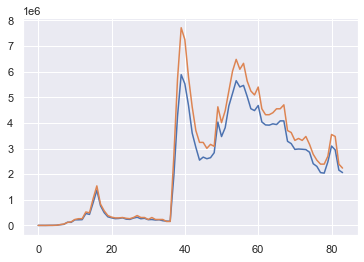

<ipython-input-39-b9b3b4d0b198>:12: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(summed_ibr/nation)


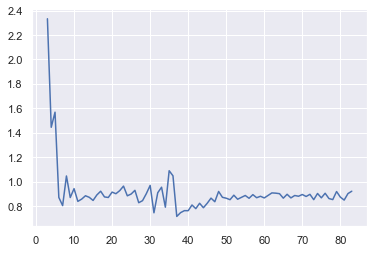

In [39]:
tmp = copy.deepcopy(raw_data_ibr_w[c])
tmp["coronavirus"] = 0
for v in raw_data_ibr_w.values():
    tmp["coronavirus"] += v["coronavirus"]

summed_ibr = np.array(tmp["coronavirus"].tolist())
nation = np.array(it_raw_data_ibr_w["coronavirus"].tolist())
plt.plot(summed_ibr)
plt.plot(nation)
#plt.yscale("log")
plt.show()
plt.plot(summed_ibr/nation)

In [40]:
raw_data_ibr_w



{'IT-65':             coronavirus
 date                   
 2020-01-15         0.00
 2020-01-16         0.00
 2020-01-17         0.00
 2020-01-18         0.00
 2020-01-19         0.00
 ...                 ...
 2020-04-03     87946.56
 2020-04-04    110496.96
 2020-04-05    108241.92
 2020-04-06     81181.44
 2020-04-07     74416.32
 
 [84 rows x 1 columns],
 'IT-77':               coronavirus
 date                     
 2020-01-15       0.000000
 2020-01-16       0.000000
 2020-01-17       0.000000
 2020-01-18       0.000000
 2020-01-19       0.000000
 ...                   ...
 2020-04-03  123969.000000
 2020-04-04  177098.571429
 2020-04-05  156437.071429
 2020-04-06  112162.428571
 2020-04-07  126920.642857
 
 [84 rows x 1 columns],
 'IT-78':             coronavirus
 date                   
 2020-01-15          0.0
 2020-01-16          0.0
 2020-01-17          0.0
 2020-01-18          0.0
 2020-01-19          0.0
 ...                 ...
 2020-04-03     105731.2
 2020-04-04     1282

In [ ]:
plt.plot(summed_pop)
plt.plot(summed_ibr)
plt.yscale("log")

In [ ]:
plt.plot(summed_pop/summed_ibr)
plt.yscale("log")

In [17]:
for i in it_raw_data_ibr_w.iterrows():
    print(str(i[0].date()),int(i[1]))

2020-01-15 0
2020-01-16 0
2020-01-17 0
2020-01-18 1404
2020-01-19 2808
2020-01-20 7020
2020-01-21 28080
2020-01-22 56160
2020-01-23 131976
2020-01-24 140400


In [41]:
it_raw_data_ibr_w.head()

,coronavirus
date,
2020-01-15,0.0
2020-01-16,0.0
2020-01-17,0.0
2020-01-18,1388.0
2020-01-19,2776.0


# Process dataframes 

In [65]:
codes = {"IT-65":"Abruzzo",
"IT-77":"Basilicata",
"IT-78":"Calabria",
"IT-72":"Campania",
"IT-45":"Emilia-Romagna",
"IT-62":"Lazio",
"IT-42":"Liguria",
"IT-25":"Lombardia",
"IT-57":"Marche",
"IT-67":"Molise",
"IT-21":"Piemonte",
"IT-75":"Puglia",
"IT-52":"Toscana",
"IT-55":"Umbria",
"IT-34":"Veneto",
"IT-36":"Friuli-Venezia Giulia",
"IT-88":"Sardegna",
"IT-82":"Sicilia",
"IT-32":"Trentino-Alto Adige/Südtirol",
"IT-23":"Valle d'Aosta/Vallée d'Aoste"
}
new = raw_data_ibr_w
#raw_data_ibr_w['IT'] = it_raw_data_pop_w


In [93]:
reg.keys()

dict_keys(['IT-65', 'IT-77', 'IT-78', 'IT-72', 'IT-45', 'IT-62', 'IT-42', 'IT-25', 'IT-57', 'IT-67', 'IT-21', 'IT-75', 'IT-52', 'IT-55', 'IT-34', 'IT-36', 'IT-88', 'IT-82', 'IT-32', 'IT-23'])

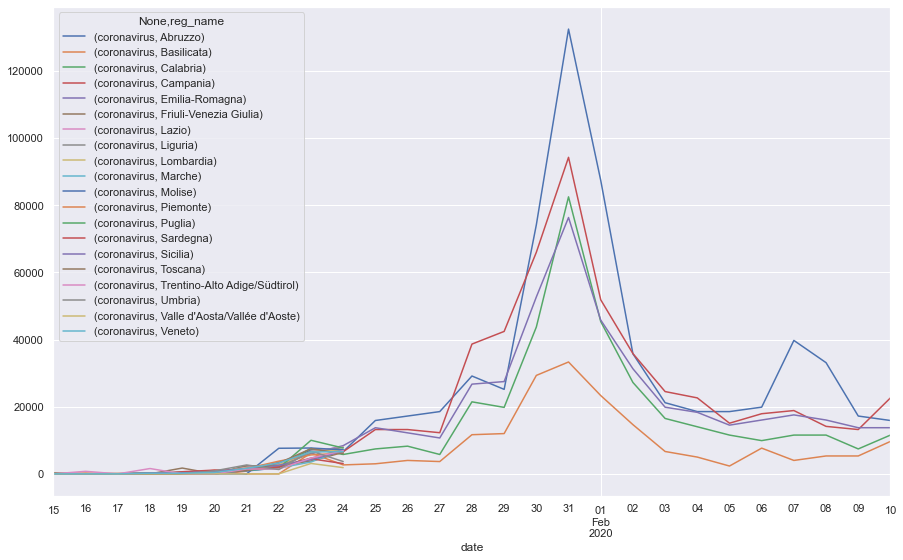

In [101]:
reg = copy.deepcopy(raw_data_ibr_w)
it = copy.deepcopy(it_raw_data_ibr_w)

df = pd.concat(reg.values(), keys=reg.keys())
df.index.names = ["region", "date"]
df=df.reset_index()
df['reg_name']=[codes[r["region"]] for i,r in df.iterrows()]

piv = pd.pivot_table(df, index=['date'],columns=['reg_name'], values=['coronavirus'])
piv.plot(figsize=(15,9))

In [96]:
out

,region,date,coronavirus,reg_name
0,IT-65,2020-01-15,0.0,Abruzzo
1,IT-65,2020-01-16,0.0,Abruzzo
2,IT-65,2020-01-17,0.0,Abruzzo
3,IT-65,2020-01-18,0.0,Abruzzo
4,IT-65,2020-01-19,0.0,Abruzzo
...,...,...,...,...
1675,IT-23,2020-04-03,371971360.0,Valle d'Aosta/Vallée d'Aoste
1676,IT-23,2020-04-04,476588305.0,Valle d'Aosta/Vallée d'Aoste
1677,IT-23,2020-04-05,325474940.0,Valle d'Aosta/Vallée d'Aoste
1678,IT-23,2020-04-06,348723150.0,Valle d'Aosta/Vallée d'Aoste


1140

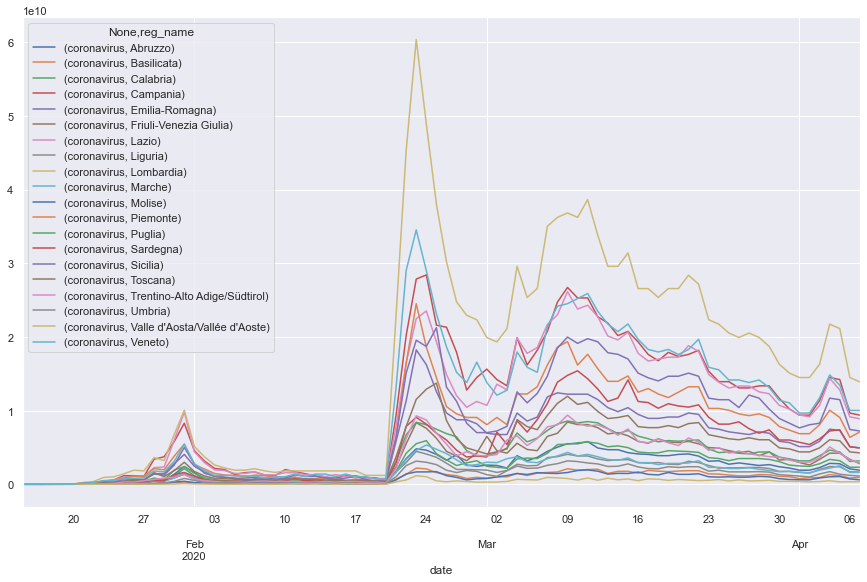

In [98]:
piv = pd.pivot_table(out, index=['date'],columns=['reg_name'], values=['coronavirus'])
piv.plot(figsize=(15,9))

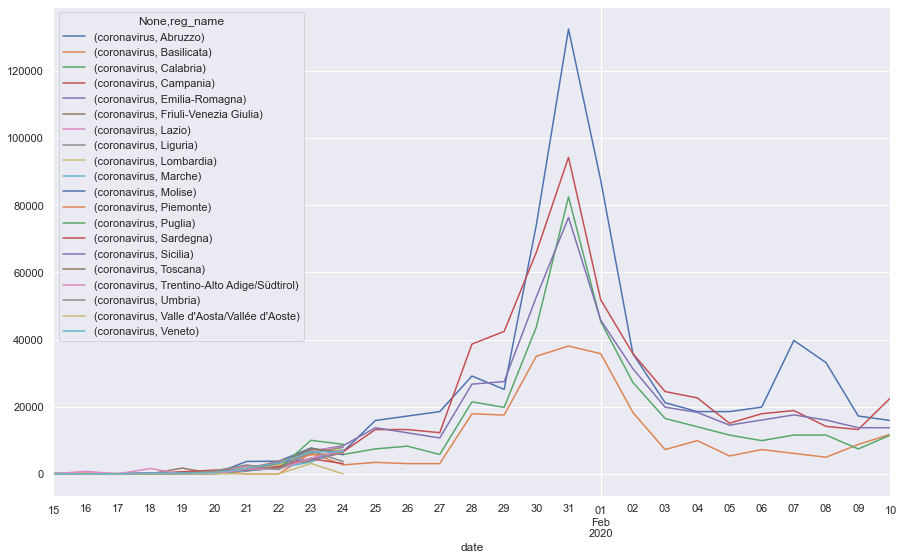

In [85]:
piv = pd.pivot_table(df, index=['date'],columns=['reg_name'], values=['coronavirus'])
piv.plot(figsize=(15,9))